# **Data augmentation to address overfitting**

**Data augmentation** is a technique used in machine learning, especially in deep learning, to increase the diversity of the training dataset without actually collecting more data. It helps reduce *overfitting*, which happens when a model learns too closely from the training data and struggles to generalize to new data.

In simple terms, data augmentation creates slightly modified copies of existing data, making it appear like there’s more data to learn from. This helps the model learn patterns in a more robust way, preventing it from "memorizing" the training data and making it more flexible with new, unseen data.

### Common Data Augmentation Techniques
For image data, common augmentation methods include:
1. **Flipping**: Horizontally flip the images, e.g., a left-facing dog image becomes right-facing.
2. **Rotation**: Rotate the image by a small angle (e.g., 15 degrees), which changes the orientation slightly without altering the object.
3. **Scaling**: Zoom in or out slightly, changing the size of objects in the image while keeping them recognizable.
4. **Color Adjustment**: Modify the brightness, contrast, or colors slightly, giving variations in lighting conditions.
5. **Cropping and Shifting**: Crop parts of the image or shift it slightly, making the model learn to focus on different areas.

### Example of Data Augmentation
Imagine we have a training dataset of 100 images of cats. Without data augmentation, the model will see these same 100 images every time, potentially leading it to overfit.

With data augmentation:
- We might flip each cat image horizontally, now giving us 100 extra flipped images.
- We rotate each cat image by a small angle, producing another 100 rotated images.

Now, instead of seeing just 100 cat images, the model sees variations of these images, totaling 300 images (original, flipped, and rotated). These variations help the model learn more general patterns of what a "cat" looks like, making it perform better on new images of cats it hasn’t seen before.

# **Data Augmentation To Address Overfitting In Flower Classification CNN**

In this notebook we will build a CNN to classify flower images. We will also see how our model overfits and how overfitting can be addressed using data augmentation. Data augmentation is a process of generating new training samples from current training dataset using transformations such as zoom, rotations, change in contrast etc

Credits: I used tensorflow offical tutorial: https://www.tensorflow.org/tutorials/images/classification as a reference and made bunch of changes to make it simpler

In below image, 4 new training samples are generated from original sample using different transformations

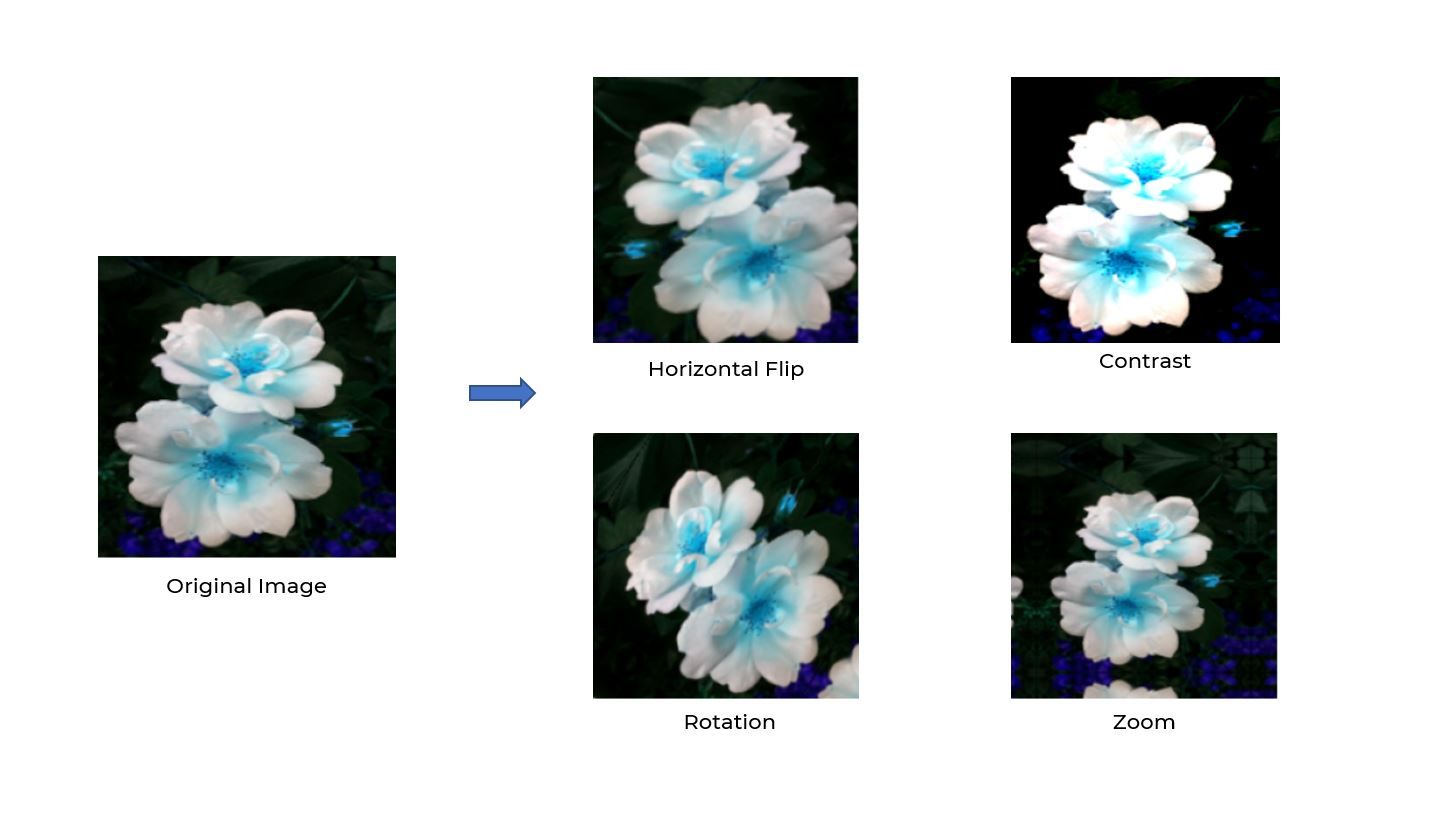

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

We will download flowers dataset from google website and store it locally. In below call it downloads the zip file (.tgz) in cache_dir which is . meaning the current folder

**Load flowers dataset**

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [3]:
data_dir

'./datasets/flower_photos'

In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [5]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/dandelion/1667963621_c76d570af3_n.jpg'),
 PosixPath('datasets/flower_photos/dandelion/8168031302_6e36f39d87.jpg'),
 PosixPath('datasets/flower_photos/dandelion/2161283279_02ea3ff8d4.jpg'),
 PosixPath('datasets/flower_photos/dandelion/3451646670_3eff7094b7_n.jpg'),
 PosixPath('datasets/flower_photos/dandelion/7062171343_db61c92737_n.jpg')]

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [7]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/12395698413_c0388278f7.jpg'),
 PosixPath('datasets/flower_photos/roses/7551637034_55ae047756_n.jpg'),
 PosixPath('datasets/flower_photos/roses/18760363474_a707331322_n.jpg'),
 PosixPath('datasets/flower_photos/roses/6209630964_e8de48fe04_m.jpg'),
 PosixPath('datasets/flower_photos/roses/17305246720_1866d6303b.jpg')]

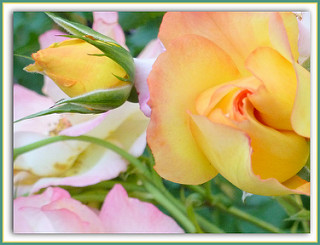

In [8]:
PIL.Image.open(str(roses[1]))

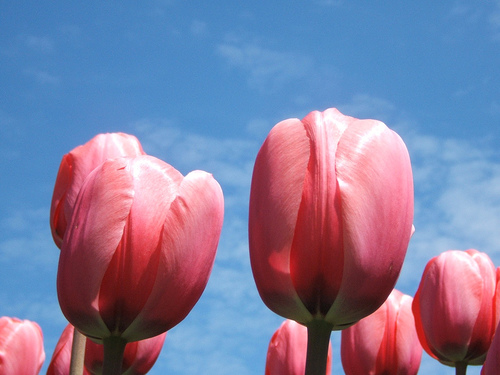

In [9]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

**Read flowers images from disk into numpy array using opencv**

In [10]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [11]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [12]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/12395698413_c0388278f7.jpg'),
 PosixPath('datasets/flower_photos/roses/7551637034_55ae047756_n.jpg'),
 PosixPath('datasets/flower_photos/roses/18760363474_a707331322_n.jpg'),
 PosixPath('datasets/flower_photos/roses/6209630964_e8de48fe04_m.jpg'),
 PosixPath('datasets/flower_photos/roses/17305246720_1866d6303b.jpg')]

In [13]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/12395698413_c0388278f7.jpg'

In [14]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [15]:
img.shape

(335, 500, 3)

In [16]:
cv2.resize(img,(180,180)).shape

(180, 180, 3)

In [17]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [18]:
X = np.array(X)
y = np.array(y)

**Train test split**

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

**Preprocessing: scale images**

In [20]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**Build convolutional neural network and train it**

In [21]:
num_classes = 5

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=30)

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.3734 - loss: 1.4803
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.5982 - loss: 1.0394
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6496 - loss: 0.8779
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 134s 982ms/step - accuracy: 0.7599 - loss: 0.6393
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.8435 - loss: 0.4021
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9126 - loss: 0.2693
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9621 - loss: 0.1418
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9806 - loss: 0.0746
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9894 - loss: 0.0461
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9938 - loss: 0.0288
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9940 - loss: 0.0241
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy:

In [22]:
model.evaluate(X_test_scaled,y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 268ms/step - accuracy: 0.6996 - loss: 2.1221


[2.2314987182617188, 0.6840958595275879]

Here we see that while train accuracy is very high (99%), the test accuracy is significantly low (66.99%) indicating overfitting. Let's make some predictions before we use data augmentation to address overfitting

In [23]:
predictions = model.predict(X_test_scaled)
predictions

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step


array([[ -9.97399   ,  18.055082  ,  11.311922  , -13.434537  ,
         -0.3711111 ],
       [  1.2338496 ,   2.6960022 ,  -9.235991  ,   0.59694755,
          2.0756226 ],
       [ -3.5797448 ,   1.726275  ,  -0.26073518,   3.7676015 ,
         -1.9842939 ],
       ...,
       [ -3.5934775 ,  -7.3741665 ,   3.780865  ,   2.3494902 ,
         -1.1649177 ],
       [ 11.41935   ,   2.5311446 , -17.085625  ,  -9.769866  ,
          5.473773  ],
       [ -1.9847037 , -10.1514225 ,   4.2199664 ,   3.5104458 ,
          2.2572227 ]], dtype=float32)

In [24]:
score = tf.nn.softmax(predictions[0])

In [25]:
np.argmax(score)

1

In [26]:
y_test[0]

1

**Improve Test Accuracy Using Data Augmentation**

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define img_height and img_width before using them
img_height = 128  # Replace with the actual height of your images
img_width = 128   # Replace with the actual width of your images

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width,3)), # Changed from layers.experimental.preprocessing.RandomFlip to layers.RandomFlip
    layers.RandomRotation(0.1), # Changed from layers.experimental.preprocessing.RandomRotation to layers.RandomRotation
    layers.RandomZoom(0.1), # Changed from layers.experimental.preprocessing.RandomZoom to layers.RandomZoom
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Original Image**

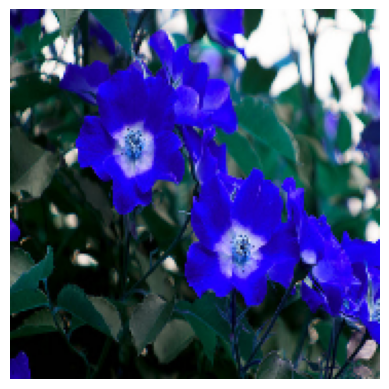

In [32]:
plt.axis('off')
plt.imshow(X[0])

**Newly generated training sample using data augmentation**

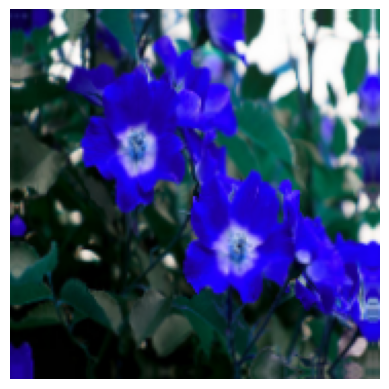

In [33]:
plt.axis('off')
plt.imshow(data_augmentation(X)[0].numpy().astype("uint8"))

**Train the model using data augmentation and a drop out layer**

In [38]:
img_height = 128
img_width = 128
num_classes = 5

# Option 1: Resizing in data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Resizing(img_height, img_width), # Resizes input images
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),  # Specify input shape
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=30)

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 58s 645ms/step - accuracy: 0.2669 - loss: 1.5868
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 76s 581ms/step - accuracy: 0.5392 - loss: 1.1209
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 579ms/step - accuracy: 0.6191 - loss: 0.9876
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 586ms/step - accuracy: 0.6581 - loss: 0.8846
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 86s 638ms/step - accuracy: 0.6863 - loss: 0.8166
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 76s 570ms/step - accuracy: 0.7035 - loss: 0.7756
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 581ms/step - accuracy: 0.7090 - loss: 0.7359
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 589ms/step - accuracy: 0.7384 - loss: 0.7120
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 590ms/step - accuracy: 0.7556 - loss: 0.6278
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 49s 565ms/step - accuracy: 0.7458 - loss: 0.6533
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 570ms/step - accuracy: 0.7412 - loss: 0.6613
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 52

In [39]:
model.evaluate(X_test_scaled,y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.7168 - loss: 0.9746


[0.9590214490890503, 0.7320261597633362]

You can see that by using data augmentation and drop out layer the accuracy of test set predictions is increased to 73.20%